In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
from typing import Tuple, Dict
from src.utils.Contact_Matrix import create_contact_matrix, matrix_scaling

def generate_matrices_and_vectors(
    df: pd.DataFrame,
    apply_sinkhorn: bool = True,
    symmetrize: bool = False,
    max_iters: int = 1000,
    threshold: float = 1e-6
) -> Tuple[Dict[str, jnp.ndarray], Dict[str, jnp.ndarray]]:
    behavior_types = ["masks", "testing", "vacc"]
    matrices = {}
    behavior_vectors = {}
    n_bins = 5
    
    for behavior_type in behavior_types:
        df_clean = df.dropna(subset=[f'{behavior_type}_self'])
        
        self_behavior = df_clean[f'{behavior_type}_self'].astype(int)
        behavior_vector = np.zeros(n_bins)
        for i in range(n_bins):
            behavior_vector[i] = np.sum(self_behavior == i+1)
        behavior_vector = behavior_vector / np.sum(behavior_vector)
        behavior_vectors[behavior_type] = jnp.array(behavior_vector)
        
        contact_matrix = np.zeros((n_bins, n_bins))
        
        if behavior_type == "vacc":
            cols = [f'{behavior_type}_others0{i+1}' for i in range(n_bins)]
        else:
            cols = [
                f'{behavior_type}_others_never', 
                f'{behavior_type}_others_sometimes',
                f'{behavior_type}_others_half',
                f'{behavior_type}_others_often',
                f'{behavior_type}_others_always'
            ]
        
        for i, row in df_clean.iterrows():
            self_idx = int(row[f'{behavior_type}_self']) - 1
            for j, col in enumerate(cols):
                if pd.notna(row[col]):
                    contact_matrix[self_idx, j] += row[col]
        
        raw_normalized = np.zeros_like(contact_matrix)
        for i in range(n_bins):
            group_count = np.sum(self_behavior == i+1)
            if group_count > 0:
                raw_normalized[i, :] = contact_matrix[i, :] / group_count
        
        if symmetrize:
            raw_normalized = 0.5 * (raw_normalized + raw_normalized.T)
        
        raw_normalized_jax = jnp.array(raw_normalized)
        
        if apply_sinkhorn:
            sinkhorn_normalized, _, _ = matrix_scaling(
                raw_normalized_jax, 
                max_iters=max_iters, 
                threshold=threshold
            )
            matrices[behavior_type] = sinkhorn_normalized * (n_bins**2)
        else:
            matrices[behavior_type] = raw_normalized_jax * (n_bins**2)
    
    return matrices, behavior_vectors

def calculate_optimal_homophily(
    matrices: Dict[str, jnp.ndarray],
    behavior_vectors: Dict[str, jnp.ndarray],
    h_range: Tuple[float, float] = (-10, 10),
    n_samples: int = 1000
) -> Tuple[Dict[str, float], Dict[str, Dict[float, float]]]:
    behavior_types = ["masks", "testing", "vacc"]
    h_values = jnp.linspace(h_range[0], h_range[1], n_samples)
    optimal_h = {}
    all_distances = {}
    
    def matrix_distance(m1, m2):
        return jnp.sqrt(jnp.sum((m1 - m2) ** 2))
    
    for behavior_type in behavior_types:
        empirical_matrix = matrices[behavior_type]
        populations = behavior_vectors[behavior_type]
        n_groups = len(populations)
        
        distances = {}
        
        for h in h_values:
            synthetic_matrix = create_contact_matrix(n_groups, h, populations)
            dist = matrix_distance(synthetic_matrix, empirical_matrix)
            distances[float(h)] = float(dist)
        
        optimal_h[behavior_type] = min(distances, key=distances.get)
        all_distances[behavior_type] = distances
    
    return optimal_h, all_distances

def calculate_h_std_dev(
    distances: Dict[float, float],
    temperature: float = 1.0
) -> Tuple[float, float, float]:
    h_values = np.array(sorted(distances.keys()))
    dist_values = np.array([distances[h] for h in h_values])
    
    min_idx = np.argmin(dist_values)
    optimal_h = h_values[min_idx]
    
    weights = np.exp(-dist_values / temperature)
    weights = weights / np.sum(weights)
    
    weighted_mean = np.sum(h_values * weights)
    variance = np.sum(weights * (h_values - weighted_mean)**2)
    std_dev = np.sqrt(variance)
    effective_n = 1.0 / np.sum(weights**2)
    
    return optimal_h, std_dev, effective_n

In [ ]:
# Load the data
csv_path = 'data_homophily.csv'
df = pd.read_csv(csv_path)

# Generate matrices and behavior vectors
matrices, behavior_vectors = generate_matrices_and_vectors(df)

# Calculate optimal homophily and distances
h_range = (-5, 5)
n_samples = 1000
optimal_h, distances = calculate_optimal_homophily(
    matrices, 
    behavior_vectors, 
    h_range=h_range,
    n_samples=n_samples
)

# Calculate standard deviations
std_devs = {}
for behavior_type in ["masks", "testing", "vacc"]:
    optimal_h_val, std_dev, effective_n = calculate_h_std_dev(distances[behavior_type])
    std_devs[behavior_type] = {
        'optimal': optimal_h_val,
        'std_dev': std_dev,
        'effective_n': effective_n
    }

# Store all results in a dictionary
results = {
    'matrices': matrices,
    'behavior_vectors': behavior_vectors,
    'optimal_h': optimal_h,
    'distances': distances,
    'std_devs': std_devs
}

In [ ]:
import matplotlib.pyplot as plt

def generate_comparison_figure_with_std(
    df: pd.DataFrame,
    matrices: Dict[str, jnp.ndarray],
    behavior_vectors: Dict[str, jnp.ndarray],
    distances: Dict[str, Dict[float, float]],
    optimal_h: Dict[str, float],
    std_devs: Dict[str, Dict[str, float]],
    figsize: Tuple[int, int] = (15, 12)
) -> plt.Figure:
    behavior_types = ["masks", "testing", "vacc"]
    behavior_labels = ["Masks", "Testing", "Vaccination"]
    
    fig, axes = plt.subplots(3, 3, figsize=figsize)
    
    for col, (behavior_type, label) in enumerate(zip(behavior_types, behavior_labels)):
        # Top row: Histogram of self-reported behavior
        ax_hist = axes[0, col]
        behavior_vector = behavior_vectors[behavior_type]
        ax_hist.bar(range(1, len(behavior_vector)+1), behavior_vector)
        ax_hist.set_title(f"{label} Self-Reported Behavior")
        ax_hist.set_xlabel("Behavior Level")
        ax_hist.set_ylabel("Proportion")
        ax_hist.set_xticks(range(1, len(behavior_vector)+1))
        ax_hist.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Middle row: Normalized contact matrix
        ax_matrix = axes[1, col]
        im = ax_matrix.imshow(matrices[behavior_type], cmap='viridis')
        ax_matrix.set_title(f"{label} Contact Matrix")
        ax_matrix.set_xlabel("Others' Behavior")
        ax_matrix.set_ylabel("Self Behavior")
        ax_matrix.set_xticks(range(len(behavior_vector)))
        ax_matrix.set_yticks(range(len(behavior_vector)))
        ax_matrix.set_xticklabels(range(1, len(behavior_vector)+1))
        ax_matrix.set_yticklabels(range(1, len(behavior_vector)+1))
        plt.colorbar(im, ax=ax_matrix)
        
        # Bottom row: L2 distance curve with standard deviation
        ax_dist = axes[2, col]
        h_vals = sorted(distances[behavior_type].keys())
        d_vals = [distances[behavior_type][h] for h in h_vals]
        ax_dist.plot(h_vals, d_vals, '-', linewidth=2)
        
        std_data = std_devs[behavior_type]
        optimal_h_val = std_data['optimal']
        std_dev = std_data['std_dev']
        
        ax_dist.axvline(x=optimal_h_val, color='r', linestyle='-', 
                       label=f'Optimal h = {optimal_h_val:.2f}')
        
        ax_dist.axvspan(
            optimal_h_val - std_dev, 
            optimal_h_val + std_dev, 
            alpha=0.2, 
            color='blue',
            label=f'h ± σ: [{optimal_h_val-std_dev:.2f}, {optimal_h_val+std_dev:.2f}]'
        )
        
        ax_dist.axvline(x=optimal_h_val - std_dev, color='blue', linestyle='--', alpha=0.5)
        ax_dist.axvline(x=optimal_h_val + std_dev, color='blue', linestyle='--', alpha=0.5)
        
        ax_dist.set_xlabel("Homophily Parameter (h)")
        ax_dist.set_ylabel("Matrix Distance")
        ax_dist.set_title(f"{label} Matrix Distance")
        ax_dist.legend()
        ax_dist.grid(True)
    
    plt.tight_layout()
    return fig

def print_homophily_summary(std_devs: Dict[str, Dict[str, float]]):
    print("Homophily Parameter Estimates with Standard Deviations:")
    print("-" * 80)
    print(f"{'Behavior':<12} {'Optimal h':<12} {'Std Dev (σ)':<12} {'h ± σ':<20} {'Effective N':<12}")
    print("-" * 80)
    
    for behavior_type, label in zip(["masks", "testing", "vacc"], ["Masks", "Testing", "Vaccination"]):
        std_data = std_devs[behavior_type]
        optimal_h_val = std_data['optimal']
        std_dev = std_data['std_dev']
        effective_n = std_data['effective_n']
        h_range_str = f"[{optimal_h_val-std_dev:.4f}, {optimal_h_val+std_dev:.4f}]"
        
        print(f"{label:<12} {optimal_h_val:<12.4f} {std_dev:<12.4f} {h_range_str:<20} {effective_n:<12.1f}")

In [ ]:
# Generate the comparison figure
fig = generate_comparison_figure_with_std(
    df,
    results['matrices'],
    results['behavior_vectors'],
    results['distances'],
    results['optimal_h'],
    results['std_devs']
)

# Print the homophily summary
print_homophily_summary(results['std_devs'])

# Save the figure if needed
save_figure = True
figure_path = 'homophily_analysis_with_std.png'
if save_figure:
    fig.savefig(figure_path, dpi=300, bbox_inches='tight')
    print(f"Figure saved to {figure_path}")

# Display the figure
plt.show()

# generate 9 combination of mu_min / mu_max

## Row 1: mu_min = [0]
## Row 2: mu_min = [0.1]
## Row 3: mu_min = [0.2]

## Col 1: mu_max = [0.5]
## Col 2: mu_max = [0.75]
## Col 3: mu_max = [1]


# generate 9 combination of mu_min / mu_max

## Row 1: mu_min = [0]
## Row 2: mu_min = [1/12]
## Row 3: mu_min = [1/6]

## Col 1: mu_max = [1/6]
## Col 2: mu_max = [3/12]
## Col 3: mu_max = [1/3]

In [7]:
np.linspace(0,1,6)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [8]:
np.linspace(0,1/3,6)

array([0.        , 0.06666667, 0.13333333, 0.2       , 0.26666667,
       0.33333333])

In [9]:
np.linspace(0,0.025,6)

array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025])

C:\Users\nel_t\AppData\Local\Temp\ipykernel_12812\3260833392.py:166: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


FileNotFoundError: [Errno 2] No such file or directory: 'normalization_figures/masks_normalization_comparison.png'

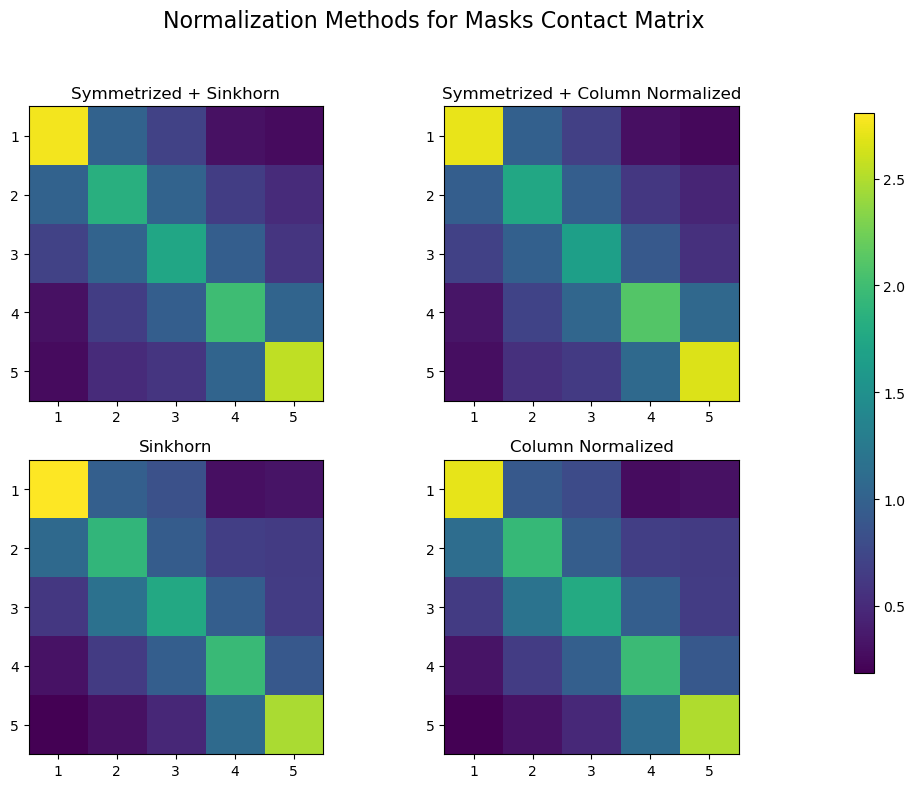

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
from src.utils.Contact_Matrix import matrix_scaling

def generate_matrices_with_normalizations(
    df: pd.DataFrame,
    behavior_type: str,
    normalizations: List[str]
) -> Dict[str, jnp.ndarray]:
    """
    Generate contact matrices with different normalization methods.
    
    Args:
        df: DataFrame with survey data
        behavior_type: Type of behavior ("masks", "testing", or "vacc")
        normalizations: List of normalization methods to apply
        
    Returns:
        Dictionary of matrices with different normalizations
    """
    normalized_matrices = {}
    n_bins = 5
    
    # Clean data
    df_clean = df.dropna(subset=[f'{behavior_type}_self'])
    self_behavior = df_clean[f'{behavior_type}_self'].astype(int)
    
    # Generate raw contact matrix
    contact_matrix = np.zeros((n_bins, n_bins))
    
    # Define columns based on behavior type
    if behavior_type == "vacc":
        cols = [f'{behavior_type}_others0{i+1}' for i in range(n_bins)]
    else:
        cols = [
            f'{behavior_type}_others_never', 
            f'{behavior_type}_others_sometimes',
            f'{behavior_type}_others_half',
            f'{behavior_type}_others_often',
            f'{behavior_type}_others_always'
        ]
    
    # Fill contact matrix
    for i, row in df_clean.iterrows():
        self_idx = int(row[f'{behavior_type}_self']) - 1
        for j, col in enumerate(cols):
            if pd.notna(row[col]):
                contact_matrix[self_idx, j] += row[col]
    
    # Apply different normalizations
    for norm_method in normalizations:
        if norm_method == "raw":
            # Store raw matrix without normalization
            normalized_matrices["raw"] = jnp.array(contact_matrix)
            continue
            
        # Step 1: Normalize by row counts (common first step)
        raw_normalized = np.zeros_like(contact_matrix)
        for i in range(n_bins):
            group_count = np.sum(self_behavior == i+1)
            if group_count > 0:
                raw_normalized[i, :] = contact_matrix[i, :] / group_count
        
        # Apply specific normalization method
        if norm_method == "column_normalized":
            # Normalize each column to sum to 1
            col_sums = raw_normalized.sum(axis=0)
            col_normalized = raw_normalized.copy()
            for j in range(n_bins):
                if col_sums[j] > 0:
                    col_normalized[:, j] = raw_normalized[:, j] / col_sums[j]
            normalized_matrices[norm_method] = jnp.array(col_normalized) * n_bins
            
        elif norm_method == "symmetrized_column_normalized":
            # First symmetrize
            symmetrized = 0.5 * (raw_normalized + raw_normalized.T)
            # Then normalize by column
            col_sums = symmetrized.sum(axis=0)
            sym_col_normalized = symmetrized.copy()
            for j in range(n_bins):
                if col_sums[j] > 0:
                    sym_col_normalized[:, j] = symmetrized[:, j] / col_sums[j]
            normalized_matrices[norm_method] = jnp.array(sym_col_normalized) * n_bins
            
        elif norm_method == "sinkhorn":
            # Apply Sinkhorn normalization
            raw_normalized_jax = jnp.array(raw_normalized)
            sinkhorn_normalized, _, _ = matrix_scaling(raw_normalized_jax)
            normalized_matrices[norm_method] = sinkhorn_normalized * (n_bins**2)
            
        elif norm_method == "symmetrized_sinkhorn":
            # First symmetrize
            symmetrized = 0.5 * (raw_normalized + raw_normalized.T)
            # Then apply Sinkhorn normalization
            symmetrized_jax = jnp.array(symmetrized)
            sinkhorn_normalized, _, _ = matrix_scaling(symmetrized_jax)
            normalized_matrices[norm_method] = sinkhorn_normalized * (n_bins**2)
    
    return normalized_matrices

def visualize_normalizations(
    df: pd.DataFrame,
    behavior_types: List[str] = ["masks", "testing", "vacc"],
    save_path: str = None
):
    """
    Visualize the impact of different normalization methods on contact matrices.
    """
    normalizations = [
        "symmetrized_sinkhorn",
        "symmetrized_column_normalized",
        "sinkhorn",
        "column_normalized"
    ]
    
    norm_labels = {
        "symmetrized_sinkhorn": "Symmetrized + Sinkhorn",
        "symmetrized_column_normalized": "Symmetrized + Column Normalized",
        "sinkhorn": "Sinkhorn",
        "column_normalized": "Column Normalized"
    }
    
    behavior_labels = {
        "masks": "Masks",
        "testing": "Testing",
        "vacc": "Vaccination"
    }
    
    # Create a figure for each behavior type
    for behavior_type in behavior_types:
        # Generate matrices with different normalizations
        matrices = generate_matrices_with_normalizations(df, behavior_type, normalizations)
        
        # Find global min/max for consistent colorbar
        all_values = np.concatenate([np.array(matrices[norm]).flatten() for norm in normalizations])
        vmin, vmax = np.min(all_values), np.max(all_values)
        
        # Create figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(10, 8))
        axes = axes.flatten()
        
        # Plot each normalization method
        for i, norm_method in enumerate(normalizations):
            ax = axes[i]
            matrix = np.array(matrices[norm_method])
            
            im = ax.imshow(matrix, cmap='viridis', vmin=vmin, vmax=vmax)
            ax.set_title(norm_labels[norm_method])
            ax.set_xticks(range(5))
            ax.set_yticks(range(5))
            ax.set_xticklabels(range(1, 6))
            ax.set_yticklabels(range(1, 6))
            
        # Add colorbar
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        
        # Set overall title
        fig.suptitle(f"Normalization Methods for {behavior_labels[behavior_type]} Contact Matrix", fontsize=16)
        plt.tight_layout(rect=[0, 0, 0.9, 0.95])
        
        if save_path:
            plt.savefig(f"{save_path}/{behavior_type}_normalization_comparison.png", dpi=300, bbox_inches='tight')
            
        plt.show()

# Load the data
csv_path = 'data_homophily.csv'
df = pd.read_csv(csv_path)

# Visualize normalizations for each behavior type
visualize_normalizations(df, save_path="normalization_figures")